In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Torch and torchvision for deep learning
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler

# Sklearn for data preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Libraries imported successfully.")

Libraries imported successfully.


In [12]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Define dataset paths
# Define dataset paths

toxic_metadata_path = "/content/drive/MyDrive/tpc-imgs/toxic_metadata.csv"
nontoxic_metadata_path = "/content/drive/MyDrive/tpc-imgs/nontoxic_metadata.csv"
full_metadata_path = "/content/drive/MyDrive/tpc-imgs/full_metadata.csv"

image_dir = "/content/drive/MyDrive/tpc-imgs"
toxic_images_dir = os.path.join(image_dir, "toxic_images")
nontoxic_images_dir = os.path.join(image_dir, "nontoxic_images")


In [15]:
toxic_metadata = pd.read_csv(toxic_metadata_path)
nontoxic_metadata = pd.read_csv(nontoxic_metadata_path)
full_metadata = pd.read_csv(full_metadata_path)

In [16]:
# Convert class_id to string for correct mapping
toxic_metadata['class_id'] = toxic_metadata['class_id'].astype(str)
nontoxic_metadata['class_id'] = nontoxic_metadata['class_id'].astype(str)

# Create a mapping from class_id to plant name
toxic_class_mapping = {row["class_id"]: (row["slang"], row["scientific_name"]) for _, row in toxic_metadata.iterrows()}
nontoxic_class_mapping = {row["class_id"]: (row["slang"], row["scientific_name"]) for _, row in nontoxic_metadata.iterrows()}


In [17]:
# Display basic info
print("\nToxic Metadata Info:")
toxic_metadata.info()
print("\nNontoxic Metadata Info:")
nontoxic_metadata.info()
print("\nFull Metadata Info:")
full_metadata.info()


Toxic Metadata Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   class_id                 5 non-null      object
 1   slang                    5 non-null      object
 2   scientific_name          5 non-null      object
 3   herbarium22_category_id  5 non-null      int64 
 4   path                     5 non-null      object
 5   search_url               5 non-null      object
dtypes: int64(1), object(5)
memory usage: 372.0+ bytes

Nontoxic Metadata Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   class_id                 5 non-null      object
 1   slang                    5 non-null      object
 2   scientific_name          5 non-null      object
 3   herb

In [18]:
# Display first few rows
print("\nToxic Metadata Sample:")
print(toxic_metadata.head())
print("\nNontoxic Metadata Sample:")
print(nontoxic_metadata.head())
print("\nFull Metadata Sample:")
print(full_metadata.head())


Toxic Metadata Sample:
  class_id               slang             scientific_name  \
0        0  Western Poison Oak  Toxicodendron diversilobum   
1        1  Eastern Poison Oak     Toxicodendron pubescens   
2        2  Eastern Poison Ivy      Toxicodendron radicans   
3        3  Western Poison Ivy     Toxicodendron rydbergii   
4        4        Poison Sumac        Toxicodendron vernix   

   herbarium22_category_id                                               path  \
0                    14625  ../input/toxic-plant-classification/tpc-imgs/t...   
1                    14626  ../input/toxic-plant-classification/tpc-imgs/t...   
2                    14627  ../input/toxic-plant-classification/tpc-imgs/t...   
3                    14628  ../input/toxic-plant-classification/tpc-imgs/t...   
4                    14629  ../input/toxic-plant-classification/tpc-imgs/t...   

                                          search_url  
0  https://www.inaturalist.org/taxa/51080-Toxicod...  
1  htt

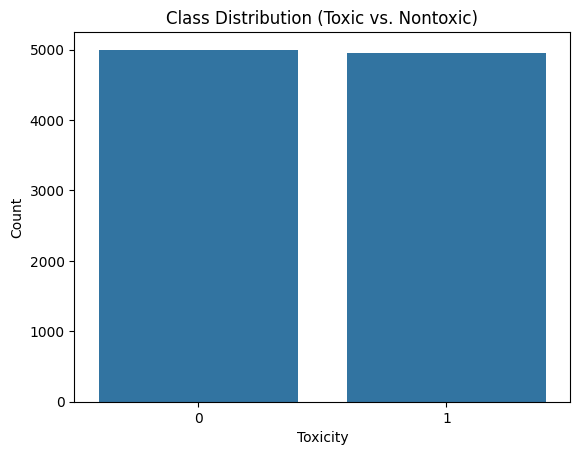

In [19]:
# Check class distribution
sns.countplot(x='toxicity', data=full_metadata)
plt.title("Class Distribution (Toxic vs. Nontoxic)")
plt.xlabel("Toxicity")
plt.ylabel("Count")
plt.show()


In [20]:
# Check for missing values
print("\nMissing Values:")
print(full_metadata.isnull().sum())



Missing Values:
class_id                   0
slang                      0
scientific_name            0
herbarium22_category_id    0
path                       0
toxicity                   0
species_label              0
dtype: int64



toxic_images: 5 plant types
  - 000 (Western Poison Oak | Toxicodendron diversilobum): 1000 images
  - 002 (Eastern Poison Ivy | Toxicodendron radicans): 1000 images
  - 004 (Poison Sumac | Toxicodendron vernix): 999 images
  - 001 (Eastern Poison Oak | Toxicodendron pubescens): 954 images
  - 003 (Western Poison Ivy | Toxicodendron rydbergii): 1000 images

nontoxic_images: 5 plant types
  - 004 (Poison Sumac | Toxicodendron vernix): 999 images
  - 003 (Western Poison Ivy | Toxicodendron rydbergii): 1000 images
  - 002 (Eastern Poison Ivy | Toxicodendron radicans): 1000 images
  - 000 (Western Poison Oak | Toxicodendron diversilobum): 1000 images
  - 001 (Eastern Poison Oak | Toxicodendron pubescens): 1000 images


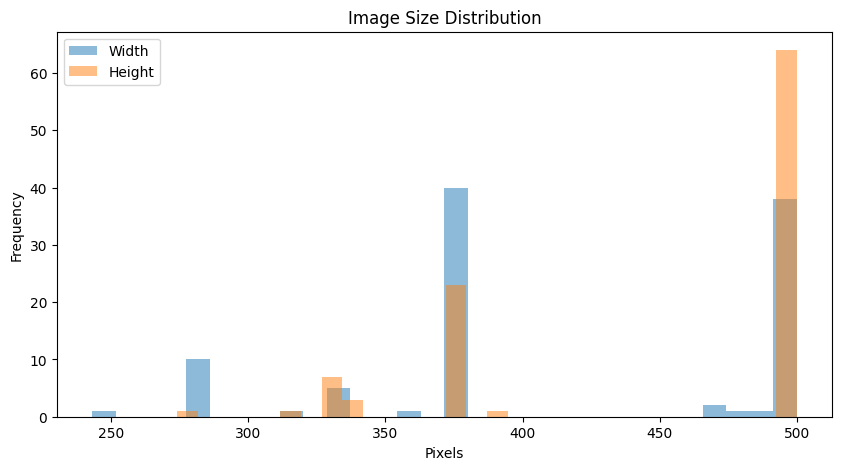

In [21]:
# Image data understanding
image_categories = ["toxic_images", "nontoxic_images"]
image_sizes = []

for category in image_categories:
    category_path = os.path.join(image_dir, category)
    plant_folders = os.listdir(category_path)
    print(f"\n{category}: {len(plant_folders)} plant types")

    for plant_folder in plant_folders:
        plant_path = os.path.join(category_path, plant_folder)
        num_images = len(os.listdir(plant_path))
        plant_name = toxic_class_mapping.get(str(int(plant_folder)), nontoxic_class_mapping.get(str(int(plant_folder)), ("Unknown", "Unknown")))
        print(f"  - {plant_folder} ({plant_name[0]} | {plant_name[1]}): {num_images} images")

        # Collect image sizes
        for img_file in os.listdir(plant_path)[:10]:  # Only sample a few images per class
            img = Image.open(os.path.join(plant_path, img_file))
            image_sizes.append(img.size)

# Plot image size distribution
image_sizes = np.array(image_sizes)
plt.figure(figsize=(10, 5))
plt.hist(image_sizes[:, 0], bins=30, alpha=0.5, label='Width')
plt.hist(image_sizes[:, 1], bins=30, alpha=0.5, label='Height')
plt.legend()
plt.title("Image Size Distribution")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.show()



Sample images from toxic_images:


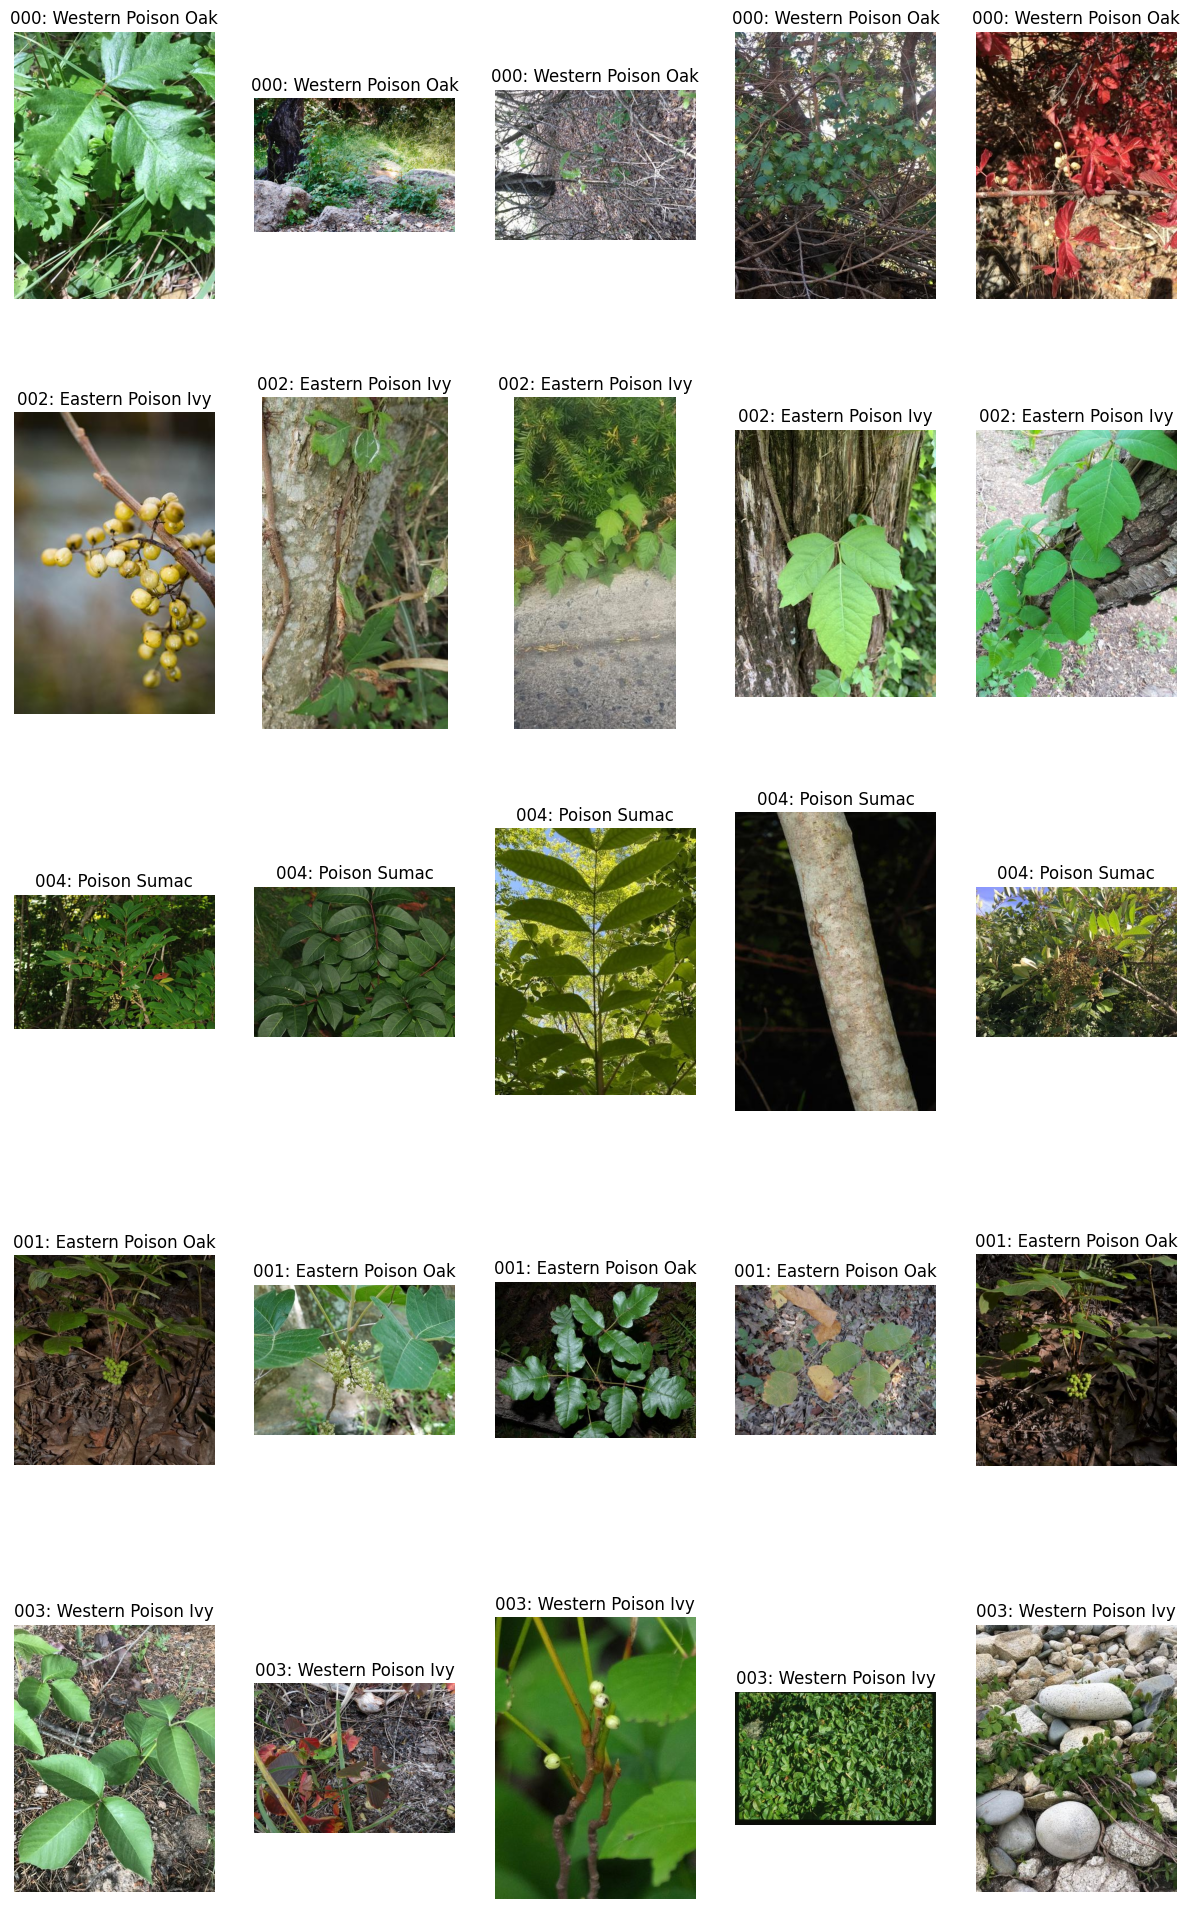


Sample images from nontoxic_images:


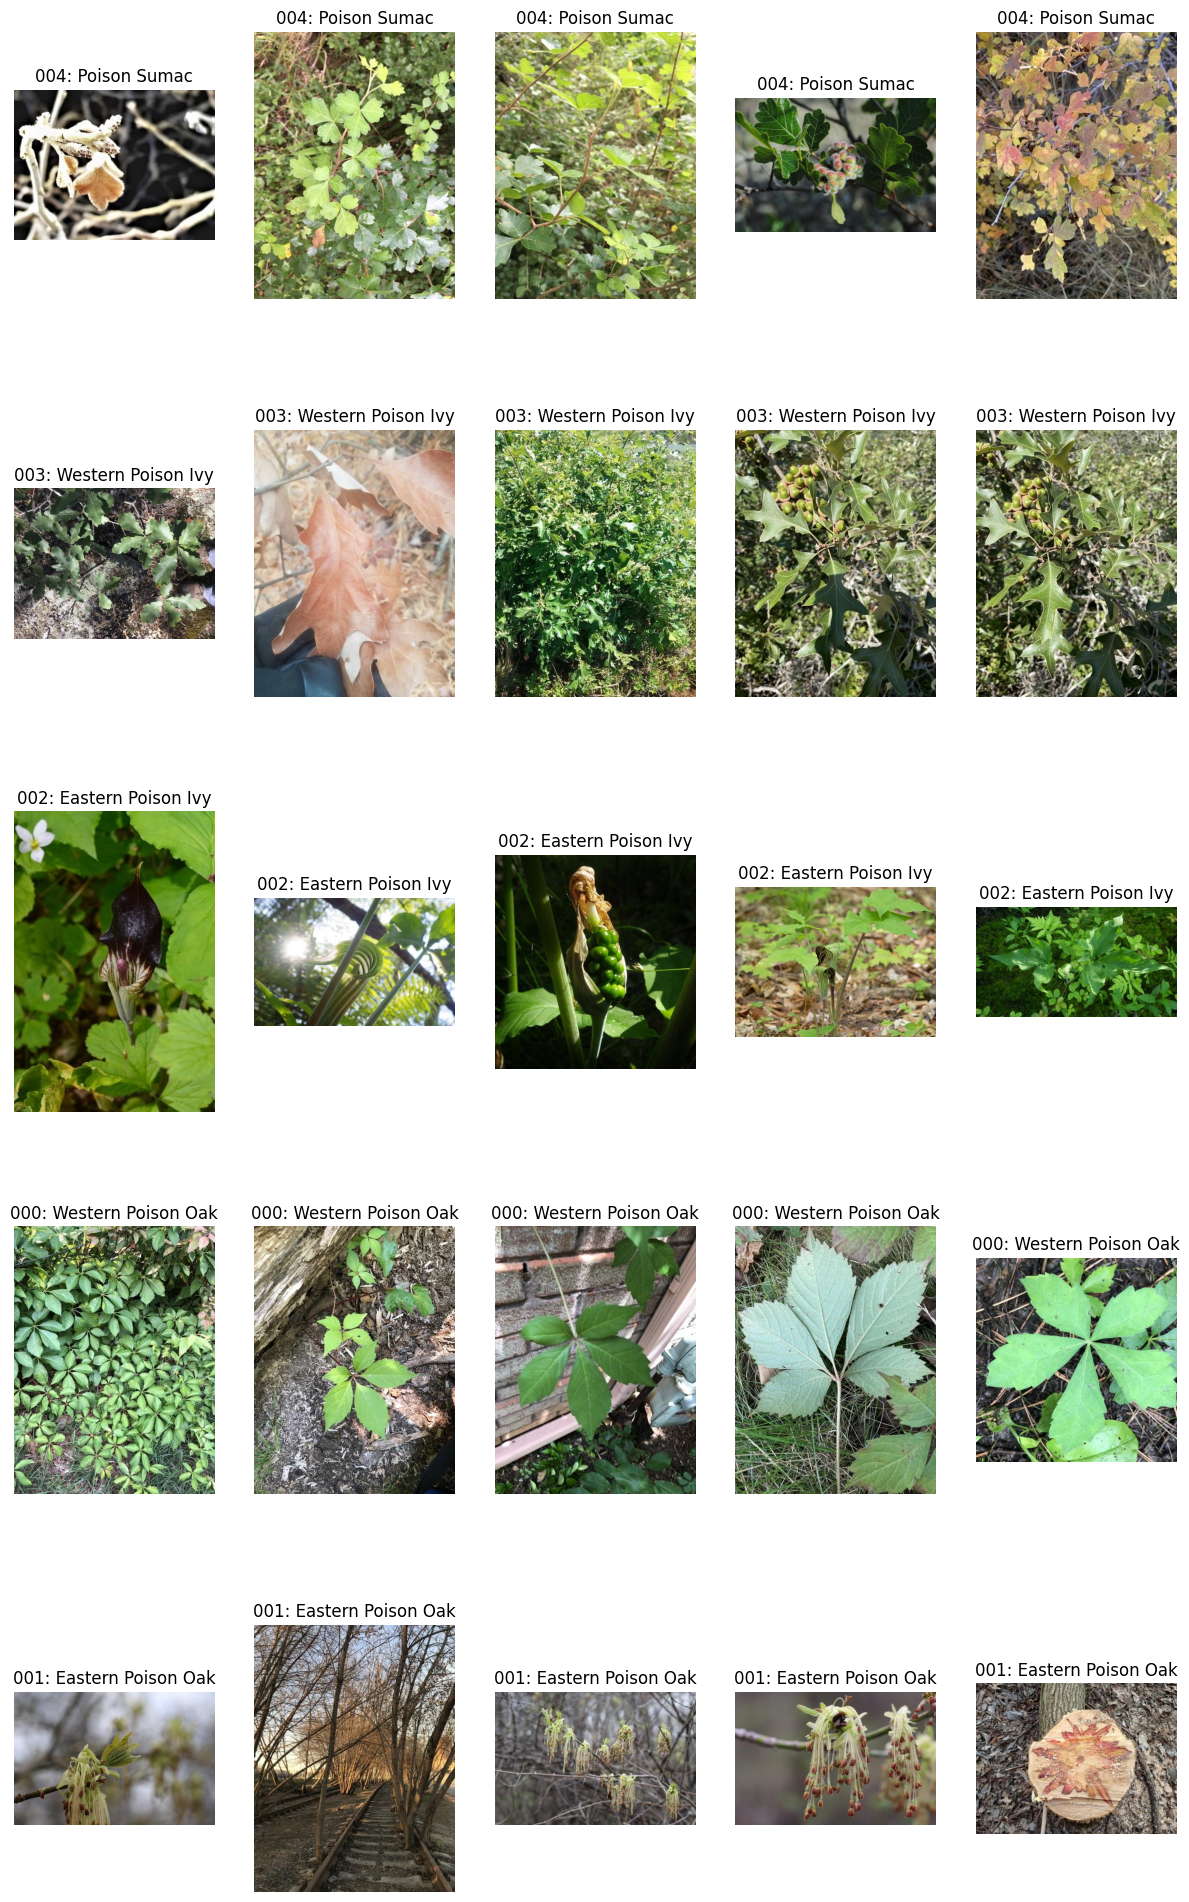

In [22]:
# Display sample images
def show_sample_images(category, num_samples=5):
    category_path = os.path.join(image_dir, category)
    plant_folders = os.listdir(category_path)

    fig, axes = plt.subplots(len(plant_folders), num_samples, figsize=(15, 5 * len(plant_folders)))
    for i, plant_folder in enumerate(plant_folders):
        plant_path = os.path.join(category_path, plant_folder)
        sample_images = [os.path.join(plant_path, img) for img in os.listdir(plant_path)[:num_samples]]

        for j, img_path in enumerate(sample_images):
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            plant_name = toxic_class_mapping.get(str(int(plant_folder)), nontoxic_class_mapping.get(str(int(plant_folder)), ("Unknown", "Unknown")))
            axes[i, j].set_title(f"{plant_folder}: {plant_name[0]}")

    plt.show()

# Show sample images from each category
for category in image_categories:
    print(f"\nSample images from {category}:")
    show_sample_images(category)

In [23]:
# Définir les transformations des images (sans conversion en noir et blanc)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



Sample transformed images:


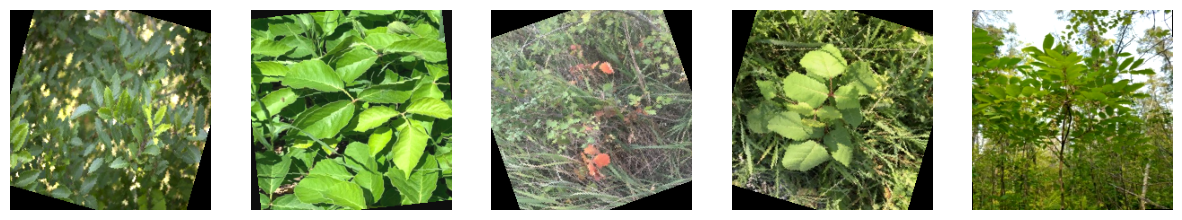

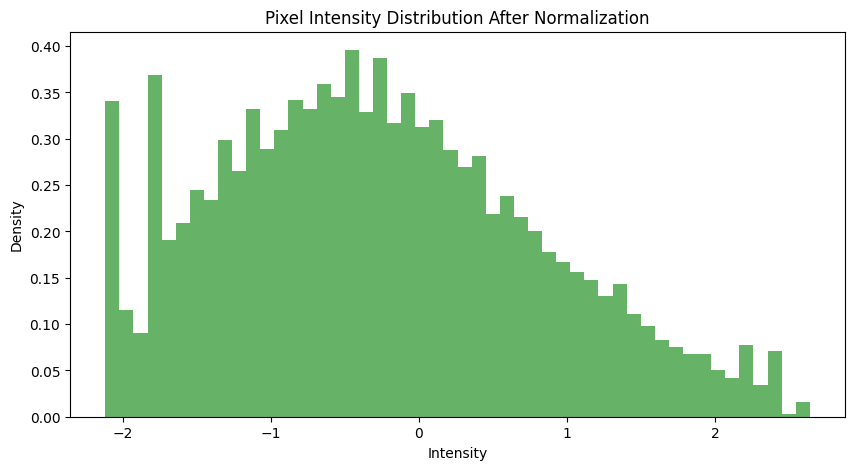

In [28]:
# Charger les datasets avec les transformations corrigées
full_dataset = datasets.ImageFolder(root=image_dir, transform=train_transform)

# Séparer en train et validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Vérifier les images transformées
def show_sample_images(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        sample_img, _ = dataset[i]  # Récupérer l'image
        sample_img = sample_img.permute(1, 2, 0)  # Convertir de (C, H, W) à (H, W, C)
        sample_img = sample_img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Dé-normalisation
        sample_img = sample_img.clamp(0, 1)  # S'assurer que les valeurs sont dans [0,1]
        axes[i].imshow(sample_img)
        axes[i].axis("off")
    plt.show()

print("\nSample transformed images:")
show_sample_images(train_dataset)

sample_pixels = []
for i in range(100):  # Prendre 100 échantillons un par un
    img, _ = train_dataset[i]
    sample_pixels.extend(img.detach().cpu().numpy().flatten())

plt.figure(figsize=(10, 5))
plt.hist(sample_pixels, bins=50, density=True, alpha=0.6, color='g')
plt.title("Pixel Intensity Distribution After Normalization")
plt.xlabel("Intensity")
plt.ylabel("Density")
plt.show()